## A neural network for customer churn prediction

The data for this assignment is sourced from Kaggle and the file is called `Telco-Customer-Churn.csv`.


Data and additional descriptions can be found at: https://www.kaggle.com/datasets/blastchar/telco-customer-churn


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

### Data cleaning and preprocessing 

1) Removed "Customer ID" as a feature since it's not necessary and after that remove dublicates from the dataset.

2) Checked the values in object columns and found that feature "TotalCharges" are not in float but in string format. Therefore, it was changed to numerical value. This transofrmation gave 11 nan values that were dropped from the dataset.

3) If there is no phone or internet service it implies that chosen service is not used and a customer will not join. Thus, categorical features which have "No phone service" or "No Internet service" is were changed to "No"

4) Categorical features which had "Yes" or "No" answers where changed to 1 or 0. Categorical features which were presented by another string representations were encoded. Continious variables were scaled using Standart Scaler

After all of these steps, I received 26 features and 1 target variable.

In [2]:
# Exercise 1
telco = pd.read_csv("Telco-Customer-Churn.csv")
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
class_probs={}
class_probs[0]=(telco['Churn']=='Yes').mean()
class_probs[1]=(telco['Churn']=='No').mean()
print("Probability that the customer will churn: ", class_probs[0].round(3))
print("Probability that the customer will not churn: ", class_probs[1].round(3))

Probability that the customer will churn:  0.265
Probability that the customer will not churn:  0.735


In [4]:
telco.shape

(7043, 21)

In [5]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Check for missing values
telco.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
# Drop the customerID since it is not nessecary
df = telco.copy()
df = df.drop(columns=["customerID"])

# Check dublicates and remove them they are present
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7021.000000,7021.000000,7021.000000
mean,0.162512,32.469449,64.851894
std,0.368947,24.534965,30.069001
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.750000
50%,0.000000,29.000000,70.400000
75%,0.000000,55.000000,89.900000
max,1.000000,72.000000,118.750000


In [9]:
# Check the values in object columns
for column in df.columns:
    if (df[column].dtypes == 'object'):
        print (f"{column} : {df[column].unique()}")

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges : ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn : ['No' 'Yes']


In [10]:
# Preprocessing

# Change column type from object to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

# If there is no phone or internet service it implies that chosen service is not used due to this problem
df.replace({'No phone service':'No'}, inplace = True)
df.replace({'No internet service':'No'}, inplace = True)

In [11]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [12]:
# Delete rows with NaN values
df = df.dropna()
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
# Encode Gender feature 
df.loc[:, 'gender'] = df['gender'].map({"Male": 0, "Female": 1})

# Encode "Yes"/ "No" features
features = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies' , 'PaperlessBilling', 'Churn']

for column in features:
    df.loc[:, column].replace({'Yes': 1, 'No': 0}, inplace=True)
    
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,1,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


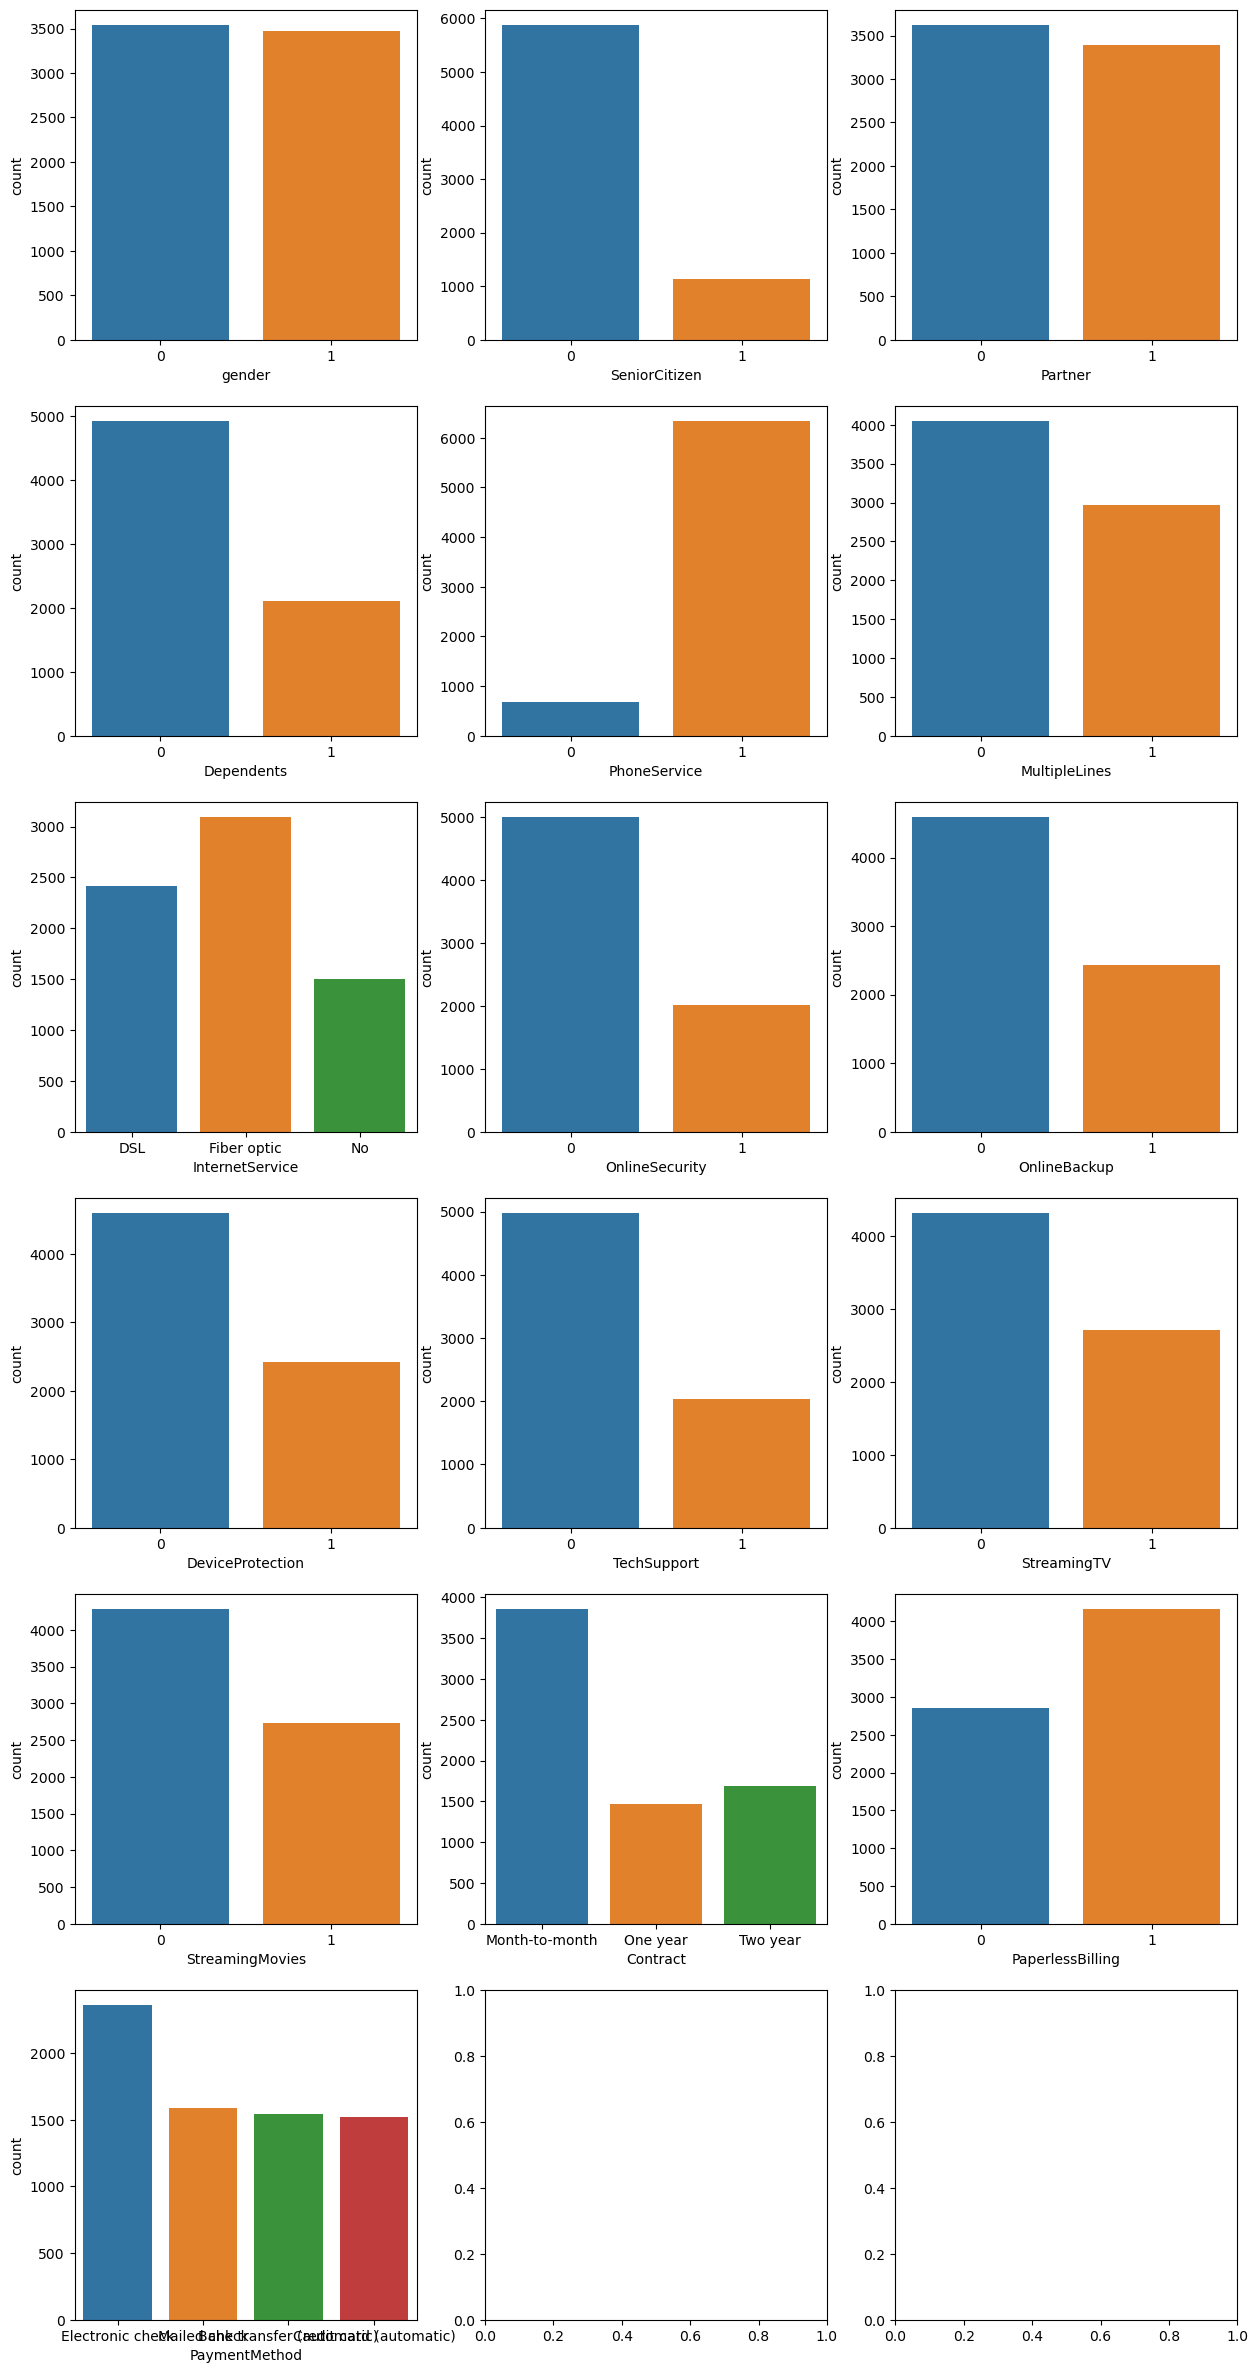

In [14]:
# Categorical features plot

fig, axes=plt.subplots(6,3, figsize=(15, 30))
axes = axes.flatten()

categories = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
              'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
              'StreamingTV', 'StreamingMovies', 'Contract','PaperlessBilling', 'PaymentMethod']

for i in range(len(categories)):
    ax= sns.countplot(x=categories[i], data = df, ax=axes[i])

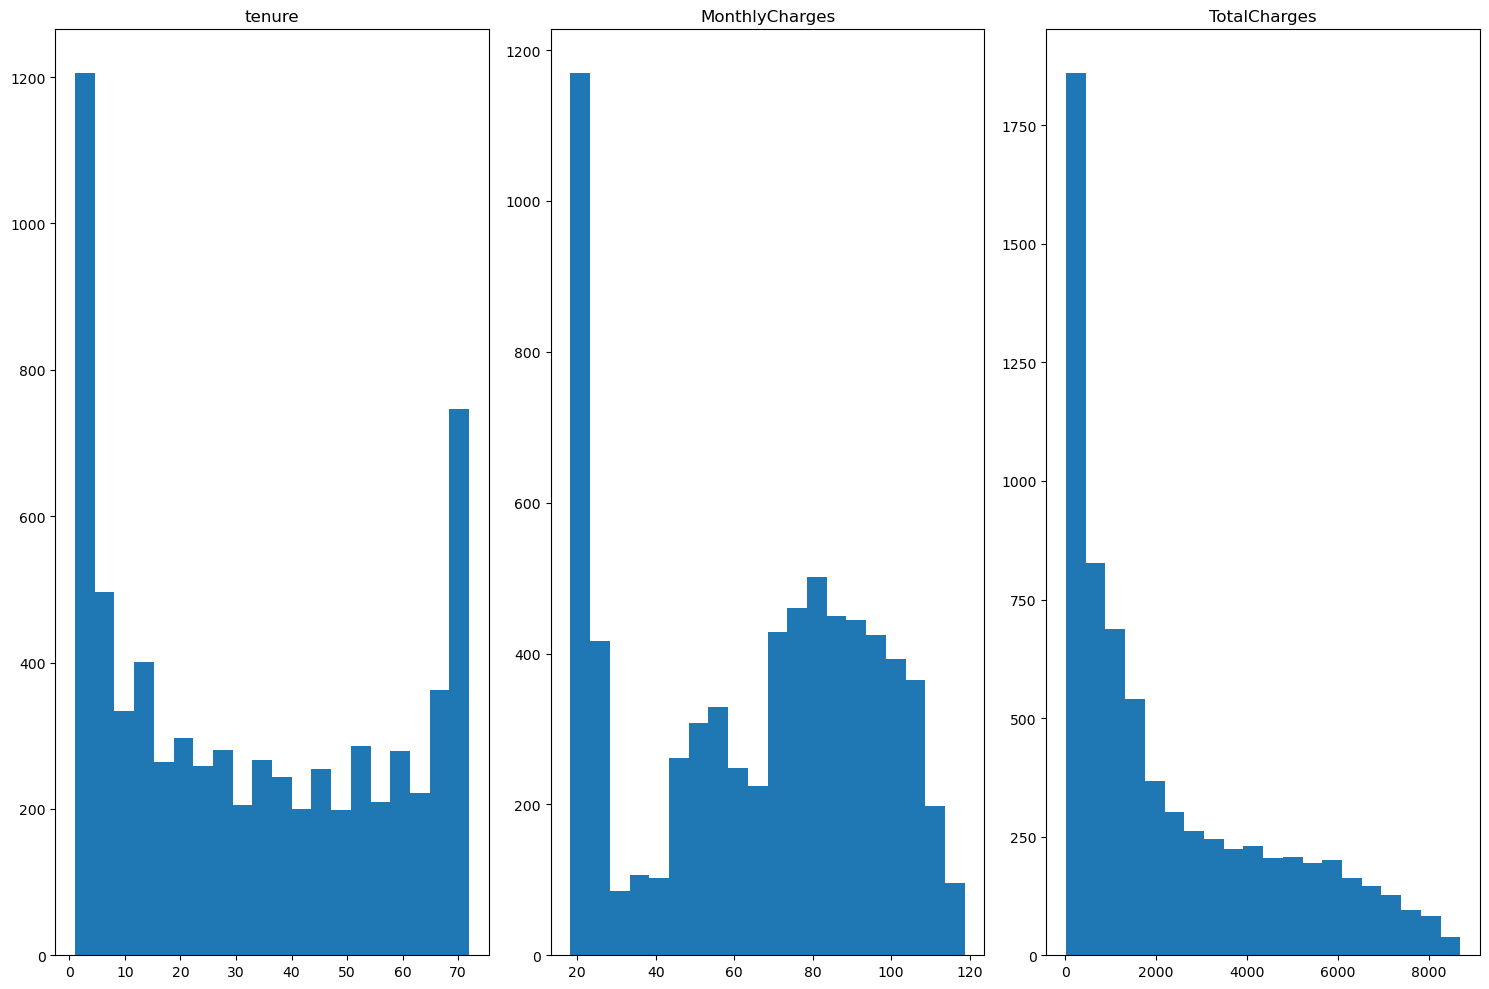

In [15]:
# Numerical feature plot

numeric = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
for i, feature in enumerate(numeric):
    axes[i].hist(df[feature], bins=20)
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()

We can observe that the data is not normally distributed

In [16]:
# Create dummy variables
dummy = ["InternetService", "Contract", "PaymentMethod"]
df = pd.get_dummies(data = df, columns = dummy)
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [17]:
df_final = df.copy()

In [18]:
# Define the continuous features for normalization
continous_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Apply normalization using StandartScaler
scaler = StandardScaler()
df_final[continous_features] = scaler.fit_transform(df_final[continous_features])
df_final.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,-1.285566,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0.060346,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,-1.244781,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0.508983,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,-1.244781,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [19]:
df_final.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

### Spliting dataset into a training set and a testing set

In [20]:
X_telco = df_final.drop('Churn', axis=1)
y_telco = df_final['Churn']
X_train, X_test, y_train, y_test = train_test_split(X_telco, y_telco, test_size=0.3, random_state=42)

In [21]:
print("X Train shape:", X_train.shape)
print("X Test shape:", X_test.shape)
print('Y Train shape:', y_train.shape)
print('Y Test shape:', y_test.shape)

X Train shape: (4907, 26)
X Test shape: (2103, 26)
Y Train shape: (4907,)
Y Test shape: (2103,)


Training data is 70% of the whole dataset, while testing is 30%.

### Design a neural network model with one hidden layer

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=10, input_shape=(26,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
print(X_train.shape,y_train.shape)

(4907, 26) (4907,)


#### Architecture discription:

Our neural network constists with three layers (one hidden):

- Input Layer: The first dense layer uses the input_shape parameter to specify the input layer. 26 features are expected in the input data since we have 26 features.

- Hidden Layer: The dense layer, which has 10 neurons, is used to produce the hidden layer. The activation function used in this layer is the rectified linear unit (ReLU). ReLU is a common activation function that incorporates non-linearity which helps the model in discovering complex patterns in the data.

- Output Layer: The third dense layer with 1 neuron specify the output layer. It uses the sigmoid activation function which bounds the output values to the range of 0 to 1. Since the model attempts to predict a binary event, the sigmoid activation is ideal to generate an output that approximate probability.

In [24]:
# Train your neural network using the training set.
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
154/154 [==============================] - 2s 6ms/step - loss: 0.6238 - accuracy: 0.6717 - val_loss: 0.5025 - val_accuracy: 0.7499
Epoch 2/50
154/154 [==============================] - 1s 4ms/step - loss: 0.4769 - accuracy: 0.7620 - val_loss: 0.4307 - val_accuracy: 0.7998
Epoch 3/50
154/154 [==============================] - 1s 4ms/step - loss: 0.4424 - accuracy: 0.7842 - val_loss: 0.4145 - val_accuracy: 0.8050
Epoch 4/50
154/154 [==============================] - 1s 3ms/step - loss: 0.4333 - accuracy: 0.7905 - val_loss: 0.4092 - val_accuracy: 0.8093
Epoch 5/50
154/154 [==============================] - 1s 4ms/step - loss: 0.4289 - accuracy: 0.7936 - val_loss: 0.4066 - val_accuracy: 0.8141
Epoch 6/50
154/154 [==============================] - 1s 4ms/step - loss: 0.4264 - accuracy: 0.7966 - val_loss: 0.4059 - val_accuracy: 0.8179
Epoch 7/50
154/154 [==============================] - 1s 4ms/step - loss: 0.4237 - accuracy: 0.7952 - val_loss: 0.4051 - val_accuracy: 0.8188
Epoch 

#### Parameters chosen:

- epochs: controls the number of complete passes through the training dataset. The model will go through the training data 50 times during training in out case.

- batch_size: controls the number of training samples to work through before the model’s internal parameters are updated. The model will update its weights after processing 32 samples since we specify the batch size is 32.

- validation_data: represents the validation dataset, which is used to evaluate the model's performance during training. After each epoch, the model's performance (accuracy, losses) on these data will be calculated and shown.

- otpimizer: the weights of the model are updated by the optimizer using the gradients determined during training. The 'Adam' optimizer is selected.

- loss function: measures the difference between the actual output and the expected output. 'binary_crossentropy' was selected as the loss function which is common in binary classification problems.

- metrics:  assess the model's performance during training. 'Accuracy' was chosen in as a metric

In [25]:
# Evaluate the performance of neural network on the testing set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

66/66 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.8136
Test accuracy: 0.8135996460914612


In [26]:
y_pred = model.predict(X_test)

# Convert the probabilities provided by the sigmoid function into a response of 1 or 0.
y_pred_final=[]
for i in y_pred:
    if i >= 0.5:
        y_pred_final.append(1)
    else:
        y_pred_final.append(0)

66/66 [==============================] - 0s 2ms/step


In [27]:
precision_nn = precision_score(y_test, y_pred_final)
print("Precision:", precision_nn.round(3))

recall_nn = recall_score(y_test, y_pred_final)
print("Recall:", recall_nn.round(3))

f1_nn = f1_score(y_test, y_pred_final)
print("F1:", f1_nn.round(3))

Precision: 0.664
Recall: 0.551
F1: 0.602


##### Interpret the results:

1) Precision: proportion of positive identifications was actually correct. In this case, the NN achieved a precision of 0.67, which suggests that when it predicted a positive instance, it was correct approximately 67% of the time.

2) Recall: proportion of actual positives was identified correctly. With a recall of 0.56, the NN captured approximately 56% of the true positive instances in the dataset.

3) F1 score: The F1 score combines the precision and recall scores of a model and computes how many times a model made a correct prediction across the entire dataset. The NN managed to achieve a nicely balanced trade-off between recall and precision, according to a value of 0.61.

4) Accuracy. The percentage of overall correct predictions is shown by the accuracy of 0.812. In this instance, the NN correctly identified the class in about 81% of the cases.


### A neural network model with one hidden layer using GridSearch

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV

# Define your model architecture
def create_model(units=10, optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(units=units, input_shape=(26,), activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create the model
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'units': [10, 20],  # Number of units in the hidden layer
    'optimizer': ['adam', 'sgd'],  # Optimization algorithms
    'activation': ['relu', 'tanh']  # Activation functions
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Print the best parameters and score
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)

C:\Users\Asus\AppData\Local\Temp\ipykernel_9224\3339721454.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)


Best parameters:  {'activation': 'relu', 'optimizer': 'adam', 'units': 20}
Best score:  0.7990785241127014


### Try a neural network with 2 hidden layers

In [29]:
model = Sequential()
model.add(Dense(units=10, input_shape=(26,), activation='relu'))
model.add(Dense(units=20, activation='relu'))  # Additional hidden layer
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='sgd',  # Stochastic Gradient Descent
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the performance of neural network on the testing set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/100
77/77 [==============================] - 2s 8ms/step - loss: 0.6657 - accuracy: 0.5975 - val_loss: 0.6010 - val_accuracy: 0.7461
Epoch 2/100
77/77 [==============================] - 0s 4ms/step - loss: 0.5853 - accuracy: 0.7318 - val_loss: 0.5668 - val_accuracy: 0.7437
Epoch 3/100
77/77 [==============================] - 0s 4ms/step - loss: 0.5604 - accuracy: 0.7314 - val_loss: 0.5441 - val_accuracy: 0.7437
Epoch 4/100
77/77 [==============================] - 0s 4ms/step - loss: 0.5402 - accuracy: 0.7316 - val_loss: 0.5237 - val_accuracy: 0.7442
Epoch 5/100
77/77 [==============================] - 0s 4ms/step - loss: 0.5214 - accuracy: 0.7367 - val_loss: 0.5042 - val_accuracy: 0.7504
Epoch 6/100
77/77 [==============================] - 0s 5ms/step - loss: 0.5040 - accuracy: 0.7471 - val_loss: 0.4866 - val_accuracy: 0.7637
Epoch 7/100
77/77 [==============================] - 0s 4ms/step - loss: 0.4891 - accuracy: 0.7591 - val_loss: 0.4714 - val_accuracy: 0.7865
Epoch 8/100
7

Epoch 59/100
77/77 [==============================] - 0s 5ms/step - loss: 0.4222 - accuracy: 0.7964 - val_loss: 0.4044 - val_accuracy: 0.8136
Epoch 60/100
77/77 [==============================] - 0s 4ms/step - loss: 0.4220 - accuracy: 0.7976 - val_loss: 0.4044 - val_accuracy: 0.8122
Epoch 61/100
77/77 [==============================] - 0s 4ms/step - loss: 0.4217 - accuracy: 0.7964 - val_loss: 0.4044 - val_accuracy: 0.8112
Epoch 62/100
77/77 [==============================] - 0s 4ms/step - loss: 0.4218 - accuracy: 0.7964 - val_loss: 0.4043 - val_accuracy: 0.8155
Epoch 63/100
77/77 [==============================] - 0s 4ms/step - loss: 0.4216 - accuracy: 0.7980 - val_loss: 0.4041 - val_accuracy: 0.8126
Epoch 64/100
77/77 [==============================] - 0s 4ms/step - loss: 0.4213 - accuracy: 0.7964 - val_loss: 0.4042 - val_accuracy: 0.8112
Epoch 65/100
77/77 [==============================] - 0s 4ms/step - loss: 0.4214 - accuracy: 0.7966 - val_loss: 0.4040 - val_accuracy: 0.8131
Epoch 

In [30]:
y_pred = model.predict(X_test)

# Converting the probabilities provided by the sigmoid function into a response of 1 or 0.
y_pred_final=[]
for i in y_pred:
    if i >= 0.5:
        y_pred_final.append(1)
    else:
        y_pred_final.append(0)

66/66 [==============================] - 0s 2ms/step


In [31]:
precision_nn = precision_score(y_test, y_pred_final)
print("Precision:", precision_nn.round(3))

recall_nn = recall_score(y_test, y_pred_final)
print("Recall:", recall_nn.round(3))

f1_nn = f1_score(y_test, y_pred_final)
print("F1:", f1_nn.round(3))

Precision: 0.677
Recall: 0.518
F1: 0.587


### Conclusion: we reached the accuracy of 81% in both case NN with 1 hidden layer or 2 layers